# Predicting The Shift

* savant leaderboard https://baseballsavant.mlb.com/visuals/team-positioning


## Goals for Modeling
* Can we predict the shift?
* Which features are most predictive?
* Use season to date stats (woba, avg launch angle/speed, etc.), lagged outcomes (whether they shifted this batter's last N PAs, whether it worked), batter id, handedness, situation (base state and run diff), avg. launch angle and exit velo, defense-team/team-year-interaction to predict whether an AB will be shifted 

### Data Notes
* Throwing out batters with <100 PA may help accuracy, but it's also unrealistic to pretend those don't exist

In [1]:
from pybaseball import statcast
from pybaseball.lahman import master
from pybaseball import playerid_reverse_lookup
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/Users/jledoux/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#df = statcast('2018-03-25','2018-08-17')

In [3]:
#df.to_csv('statcast_0817.csv')

### Use Statcast data 2015 - present. Only consider regular-season games.


In [4]:
#df = pd.read_csv('statcast_0817.csv')
# using a csv of statcast events April 2015 - Aug. 2018
df = pd.read_csv('/Users/jledoux/Documents/projects/Saber/baseball-data/statcast_with_shifts.csv')

In [5]:
df['game_date'] = pd.to_datetime(df['game_date'])

In [6]:
# R == 'regular season'
df.game_type.value_counts()

R    2681102
S     136451
D      15296
L       9167
W       5777
F       1738
Name: game_type, dtype: int64

In [7]:
# only consider regular season games
df = df.loc[df['game_type'] == 'R',]

In [8]:
df.columns

Index(['Unnamed: 0', 'index', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       'events', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'pos2_person_id', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pos1_person_id',
       'pos2_person_id.1', 'pos3_person_id', 'pos4_person_id',
       'pos5_person_id', 'pos6_person_id', 'pos7_person

### Bring in batter names because savant only gives pitcher or batter name, not both. Use bbref ids to connect w/ Lahman to get batter handedness. 

In [9]:
batters = df.batter
names = playerid_reverse_lookup(batters)
names['batter_name'] = names['name_first'] + ' ' + names['name_last']

Gathering player lookup table. This may take a moment.


In [10]:
master = master()
master = master[['bbrefID', 'bats']]
names = names.merge(master, left_on='key_bbref', right_on = 'bbrefID', suffixes=('_chadwick', '_lahman'))
names = pd.DataFrame(names[['key_mlbam', 'batter_name', 'bats']])

In [11]:
df.batter = df.batter.astype(int) 
df = df.merge(names, left_on='batter', right_on = 'key_mlbam', suffixes=('_old', ''))

In [12]:
df.if_fielding_alignment.value_counts()

Standard         1940129
Infield shift     337216
Strategic         224610
Name: if_fielding_alignment, dtype: int64

In [13]:
df.of_fielding_alignment.value_counts()

Standard                  2318411
Strategic                  183313
4th outfielder                196
Extreme outfield shift         35
Name: of_fielding_alignment, dtype: int64

In [14]:
df.head()

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,key_mlbam,batter_name,bats
0,0,34,SL,2018-08-16,92.6,-2.7631,5.4984,Koda Glover,425877,606983.0,...,5.0,5.0,4.0,4.0,5.0,Standard,Standard,425877,yadier molina,R
1,79,548,SL,2018-08-16,86.0,-3.4888,6.3423,Justin Miller,425877,502522.0,...,5.0,5.0,4.0,4.0,5.0,Standard,Standard,425877,yadier molina,R
2,80,556,FF,2018-08-16,94.2,-3.2326,6.3325,Justin Miller,425877,502522.0,...,5.0,5.0,4.0,4.0,5.0,Standard,Standard,425877,yadier molina,R
3,81,568,FF,2018-08-16,93.3,-3.3782,6.4501,Justin Miller,425877,502522.0,...,5.0,5.0,4.0,4.0,5.0,Standard,Standard,425877,yadier molina,R
4,82,576,FF,2018-08-16,93.5,-3.2965,6.4346,Justin Miller,425877,502522.0,...,5.0,5.0,4.0,4.0,5.0,Standard,Standard,425877,yadier molina,R


### Create a temporary shift column indicating whether the IF is shifted at a given pitch. Sum over this for each atbat. Atbats where a shift happened at least once will reveive a positive flag for the variable is_shift. Otherwise, it equals zero. 

Two potential flaws with this: first, what if there was a pinch hitter partway through the atbat? In this case, there's no event for the first batter, so that batter-PA pair will be thrown out. Not a problem.

Second, this doesn't take into account the possibility of changing shift states partway through an AB. If they shift at any point, I'm calling it a shifted-atbat. I don't expect that to have a major impact on the results. 

In [15]:
df['atbat_pk'] = df['game_pk'].astype(str) + df['at_bat_number'].astype(str)
df['is_shift'] = np.where(df['if_fielding_alignment'] == 'Infield shift', 1, 0)

In [16]:
df.is_shift.value_counts()

0    2223513
1     337216
Name: is_shift, dtype: int64

In [17]:
shifts = pd.DataFrame(df.groupby('atbat_pk')['is_shift'].sum()).reset_index()
shifts.loc[shifts.is_shift > 0, 'is_shift'] = 1

In [18]:
df = df.merge(shifts, on='atbat_pk', suffixes=('_old', ''))

### Create features for whether a player was on 1b, 2b, 3b at beginning of PA. Group by  atbat pk, take the first, and use that as the column's value. 

This is only an approximation of what's happening in reality, as steals, passed balls, etc. can all cause this to change throughout the life of an atbat, but it's a simple feature that impacts beginning-of-PA shift strategy.

In [19]:
df['man_on_first'] = np.where(df['on_1b'] > 0 , 1, 0)
df['man_on_second'] = np.where(df['on_2b'] > 0 , 1, 0)
df['man_on_third'] = np.where(df['on_3b'] > 0 , 1, 0)
df['men_on_base'] = df['man_on_first'] + df['man_on_second'] + df['man_on_third']

In [20]:
df[['on_1b', 'on_2b', 'on_3b', 'man_on_first', 'man_on_second', 'man_on_third', 'men_on_base']].head()

,on_1b,on_2b,on_3b,man_on_first,man_on_second,man_on_third,men_on_base
0,572761.0,607231.0,NaN,1,1,0,2
1,621550.0,NaN,NaN,1,0,0,1
2,621550.0,NaN,NaN,1,0,0,1
3,621550.0,NaN,NaN,1,0,0,1
4,621550.0,NaN,NaN,1,0,0,1


In [21]:
df['score_differential'] = df['fld_score'] - df['bat_score']

In [22]:
# drop rows where our value of interest is unknown
# if you drop the original column you'll lose partial atbats. sometimes it's null for only some pitches. dropping it loses event data.
print(df.shape)
df = df[pd.notnull(df['is_shift'])]
print(df.shape)

(2560729, 102)
(2560729, 102)


In [23]:
df.is_shift.value_counts()

0    2177433
1     383296
Name: is_shift, dtype: int64

### Some quick sanity checks to make sure these woba and shift numbers match up with Savant and FanGraphs.

My shift rates are higher than Savant's, but Savant also has lower PA-numbers than me. My PA numbers match FanGraphs', so I think my numbers are correct and Savant is doing some type of filtering that they aren't explaining on their leaderboard page. 

Differences aside, my shift leaderboard ranks similarly to Savant's and my wOBA numbers are also reaonably close to FG's.  

wOBA leaders:

In [24]:
# I want to use woba as a feature in this model. let's make sure these values are close to reality
# looks good https://baseballsavant.mlb.com/expected_statistics
woba_leaderboard = df.groupby(['batter_name', 'batter'])['woba_value'].agg(['mean', 'count'])
woba_leaderboard.loc[woba_leaderboard['count']>100,].sort_values('mean', ascending=False).head()

,,mean,count
batter_name,batter,,
mike trout,545361,0.434081,2318
aaron judge,592450,0.417219,1208
joey votto,458015,0.414840,2564
j. d. martinez,502110,0.413254,2154
paul goldschmidt,502671,0.402363,2581


Shift leaders: 

A lefty-heavy leaderboard. No righties in sight.

In [25]:
shifted_leaderboard = df.groupby(['batter_name', 'batter', 'bats'])['is_shift'].agg(['mean', 'count'])
shifted_leaderboard.loc[shifted_leaderboard['count']>1500,].sort_values('mean', ascending=False).head(15)

,,,mean,count
batter_name,batter,bats,,
ryan howard,429667,L,0.900306,3270
chris davis,448801,L,0.897624,9387
david ortiz,120074,L,0.859473,4967
joey gallo,608336,L,0.806276,4780
lucas duda,446263,L,0.789313,6232
brandon moss,461235,L,0.760622,5531
brian mccann,435263,L,0.744450,6351
adam laroche,425560,L,0.731132,1908
colby rasmus,458675,L,0.722235,4367


### Next: get this data to plate appearance level rather than pitch level

In [26]:
# for game-state variables we care about the beginning of the PA, since that mostly determines strategy
plate_appearances = df.sort_values(['game_date', 'at_bat_number'], ascending=True).groupby(['atbat_pk']).first().reset_index()

In [27]:
# get final event of the PA, as this will say single/hr/k/walk/etc
events = df.sort_values(['game_date', 'at_bat_number'], ascending=True).groupby(['atbat_pk']).last().reset_index()
events = events[['atbat_pk', 'events', 'woba_value']]

In [28]:
plate_appearances = plate_appearances.merge(events, on='atbat_pk', suffixes=['_ignore', ''])

In [29]:
# remove PAs with no event. these are probably PAs with pinch hitters.  (< 1% of observations)
plate_appearances = plate_appearances.loc[plate_appearances.events.isnull()==False,]

In [30]:
plate_appearances.loc[plate_appearances.batter_name=='javier baez',].tail(10)

,atbat_pk,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,...,bats,is_shift_old,is_shift,man_on_first,man_on_second,man_on_third,men_on_base,score_differential,events,woba_value
660160,531202.09.0,9663,11001,FT,2018-08-14,91.4,-1.5425,6.0545,Jhoulys Chacin,595879,...,R,1,1,0,0,0,0,3.0,field_out,0.0
661003,531217.021.0,5384,6181,SL,2018-08-15,83.6,-1.8308,5.8718,Junior Guerra,595879,...,R,1,1,0,0,0,0,-2.0,triple,1.6
661019,531217.037.0,5341,5579,FS,2018-08-15,87.8,-2.0453,5.6206,Junior Guerra,595879,...,R,0,0,0,1,0,1,-3.0,strikeout,0.0
661032,531217.05.0,5432,6849,FF,2018-08-15,92.5,-1.6222,5.8884,Junior Guerra,595879,...,R,1,1,0,0,0,0,0.0,field_out,0.0
661036,531217.053.0,5277,4683,FF,2018-08-15,96.1,-1.9602,5.1335,Taylor Williams,595879,...,R,1,1,0,0,0,0,-5.0,field_out,0.0
661056,531217.073.0,5200,3627,KC,2018-08-15,82.3,-0.9190,5.8976,Jeremy Jeffress,595879,...,R,1,1,0,0,0,0,-4.0,single,0.9
661629,531226.01.0,2361,2945,CU,2018-08-16,80.6,-2.5701,6.1254,Ivan Nova,595879,...,R,0,0,0,0,0,0,0.0,strikeout,0.0
661636,531226.016.0,2305,2383,FT,2018-08-16,91.8,-2.5782,6.1773,Ivan Nova,595879,...,R,0,0,0,0,0,0,0.0,single,0.9
661651,531226.032.0,2242,1750,FT,2018-08-16,92.6,-2.7376,6.0963,Ivan Nova,595879,...,R,0,0,0,0,0,0,-1.0,field_out,0.0
661669,531226.050.0,2170,1035,FF,2018-08-16,93.0,-2.9964,5.9277,Richard Rodriguez,595879,...,R,0,0,0,1,0,1,-1.0,strikeout,0.0


Shift Leaderboard (count = PAs, sum = number of shifts against, mean = % of PAs shifted against)

In [31]:
shifted_leaderboard = plate_appearances.groupby(['game_year','batter_name', 'batter', 'bats'])['is_shift'].agg(['mean', 'count', 'sum'])
shifted_leaderboard.loc[shifted_leaderboard['count']>150,].sort_values('mean', ascending=False).head(15)

mean  count  sum
game_year batter_name       batter bats                      
2016.0    ryan howard       429667 L     0.944904    363  343
2017.0    chris davis       448801 L     0.940385    520  489
2018.0    chris davis       448801 L     0.921951    410  378
2016.0    chris davis       448801 L     0.916418    670  614
2018.0    joey gallo        608336 L     0.891304    460  410
          curtis granderson 434158 L     0.863222    329  284
2016.0    david ortiz       120074 L     0.862839    627  541
2017.0    lucas duda        446263 L     0.853608    485  414
2015.0    ryan howard       429667 L     0.833992    506  422
2017.0    joey gallo        608336 L     0.832707    532  443
2018.0    matt carpenter    572761 L     0.831663    499  415
2016.0    lucas duda        446263 L     0.831395    172  143
2018.0    lucas duda        446263 L     0.826230    305  252
2015.0    david ortiz       120074 L     0.815961    614  501
          chris davis       448801 L     0.802083    672  539

### Make features numeric / model-ready
* drop unwanted columns
* create dummies of categoricals / text columns
* create averages from ones that make more sense as season-to-date (eg woba). Can I do moving averages to have this accurate at all points in time w/ no date leakage?

In [32]:
drops = ['Unnamed: 0', 'index', 'pitch_type', 'release_pos_x', 'release_pos_z', 'player_name',
        'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone',
        'des', 'type', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'hc_x', 'hc_y',
        'tfs_deprecated', 'tfs_zulu_deprecated', 'pos2_person_id', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
        'sz_top', 'sz_bot', 'release_spin_rate', 'release_extension', 'pos1_person_id', 'pos2_person_id.1',
        'pos3_person_id', 'pos4_person_id', 'pos5_person_id', 'pos6_person_id', 'pos7_person_id', 'pos8_person_id',
        'pos9_person_id', 'release_pos_y', 'home_score', 'away_score', 'post_away_score',
        'post_home_score', 'post_bat_score', 'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment',
        'release_speed', 'events_ignore','description', 'estimated_ba_using_speedangle', 'woba_value_ignore',
        'fld_score', 'is_shift_old', 'game_type', 'bats', 'balls', 'strikes', 'umpire']
plate_appearances = plate_appearances.drop(drops, 1)

In [33]:
plate_appearances.columns

Index(['atbat_pk', 'game_date', 'batter', 'pitcher', 'stand', 'p_throws',
       'home_team', 'away_team', 'hit_location', 'bb_type', 'game_year',
       'outs_when_up', 'inning', 'inning_topbot', 'hit_distance_sc',
       'launch_speed', 'launch_angle', 'effective_speed', 'game_pk',
       'estimated_woba_using_speedangle', 'woba_denom', 'babip_value',
       'iso_value', 'launch_speed_angle', 'at_bat_number', 'pitch_number',
       'pitch_name', 'bat_score', 'key_mlbam', 'batter_name', 'is_shift',
       'man_on_first', 'man_on_second', 'man_on_third', 'men_on_base',
       'score_differential', 'events', 'woba_value'],
      dtype='object')

In [34]:
# create lagged features to represent a player's past n PAs

### get average-to-date for each PA / player to avoid info leakage

The grouped features will share an index with the original dataframe, so reset the index and join on this + batter id
Do for:
* woba (expanding mean)
* babip
* plate appearances (rolling sum)
* launch angle (expanding mean)
* exit velo (expanding mean)
* hit_distance_sc (expanding mean)

Small sample properties mean these expanding means will behave erratically at first. For this reason I may end up ignoring observations with rolling average PA < N (n = 100 maybe). 


In [35]:
#get average-to-date for each PA / player to avoid info leakage
woba_to_date = plate_appearances.sort_values(['batter','game_date','at_bat_number'], ascending=True).groupby('batter')['woba_value'].expanding(min_periods=1).mean()

In [36]:
pd.DataFrame(pd.DataFrame(woba_to_date).sort_index()).shape

(661744, 1)

In [37]:
plate_appearances.shape

(661744, 38)

In [38]:
plate_appearances = plate_appearances.sort_values(['batter', 'game_date', 'at_bat_number'], ascending=True)
woba_to_date = pd.DataFrame(woba_to_date).reset_index()
woba_to_date.columns = ['batter', 'index', 'woba']
plate_appearances = plate_appearances.reset_index()
plate_appearances = pd.merge(left=plate_appearances, right=woba_to_date, left_on=['batter','index'],
                             right_on=['batter', 'index'], suffixes=['old',''])

In [39]:
backup = plate_appearances

In [40]:
plate_appearances = backup

In [41]:
# for babip:
# note: this is just averaging the babip_value. It's much lower than actual babip bc doesn't throw out PAs not included in babip.
plate_appearances = plate_appearances.sort_values(['batter', 'game_date', 'at_bat_number'], ascending=True)
babip_to_date = plate_appearances.sort_values(['batter','game_date','at_bat_number'], ascending=True).groupby('batter')['babip_value'].expanding(min_periods=1).mean()
babip_to_date = pd.DataFrame(babip_to_date).reset_index()
babip_to_date.columns = ['batter', 'index', 'babip']
plate_appearances = plate_appearances.drop('index',1)
plate_appearances = plate_appearances.reset_index()
plate_appearances = pd.merge(left=plate_appearances, right=babip_to_date, left_on=['batter','index'],
                             right_on=['batter', 'index'], suffixes=['old',''])

# for launch angle
plate_appearances = plate_appearances.sort_values(['batter', 'game_date', 'at_bat_number'], ascending=True)
launch_angle_to_date = plate_appearances.sort_values(['batter','game_date','at_bat_number'], ascending=True).groupby('batter')['launch_angle'].expanding(min_periods=1).mean()
launch_angle_to_date = pd.DataFrame(launch_angle_to_date).reset_index()
launch_angle_to_date.columns = ['batter', 'index', 'launch_angle']
plate_appearances = plate_appearances.drop('index',1)
plate_appearances = plate_appearances.reset_index()
plate_appearances = pd.merge(left=plate_appearances, right=launch_angle_to_date, left_on=['batter','index'],
                             right_on=['batter', 'index'], suffixes=['old',''])

# for exit velo: 
plate_appearances = plate_appearances.sort_values(['batter', 'game_date', 'at_bat_number'], ascending=True)
launch_speed_to_date = plate_appearances.sort_values(['batter','game_date','at_bat_number'], ascending=True).groupby('batter')['launch_speed'].expanding(min_periods=1).mean()
launch_speed_to_date = pd.DataFrame(launch_speed_to_date).reset_index()
launch_speed_to_date.columns = ['batter', 'index', 'launch_speed']
plate_appearances = plate_appearances.drop('index',1)
plate_appearances = plate_appearances.reset_index()
plate_appearances = pd.merge(left=plate_appearances, right=launch_speed_to_date, left_on=['batter','index'],
                             right_on=['batter', 'index'], suffixes=['old',''])

# for hit distance
plate_appearances = plate_appearances.sort_values(['batter', 'game_date', 'at_bat_number'], ascending=True)
hit_distance_sc = plate_appearances.sort_values(['batter','game_date','at_bat_number'], ascending=True).groupby('batter')['hit_distance_sc'].expanding(min_periods=1).mean()
hit_distance_sc = pd.DataFrame(hit_distance_sc).reset_index()
hit_distance_sc.columns = ['batter', 'index', 'hit_distance_sc']
plate_appearances = plate_appearances.drop('index',1)
plate_appearances = plate_appearances.reset_index()
plate_appearances = pd.merge(left=plate_appearances, right=hit_distance_sc, left_on=['batter','index'],
                             right_on=['batter', 'index'], suffixes=['old',''])



In [42]:
# for is_shift (shift percentage to date on all dates)
plate_appearances = plate_appearances.sort_values(['batter', 'game_date', 'at_bat_number'], ascending=True)
shifts_to_date = plate_appearances.sort_values(['batter','game_date','at_bat_number'], ascending=True).groupby('batter')['is_shift'].expanding(min_periods=1).mean()
shifts_to_date = pd.DataFrame(shifts_to_date).reset_index()
shifts_to_date.columns = ['batter', 'index', 'avg_shifted_against']
plate_appearances = plate_appearances.drop('index',1)
plate_appearances = plate_appearances.reset_index()
plate_appearances = pd.merge(left=plate_appearances, right=shifts_to_date, left_on=['batter','index'],
                             right_on=['batter', 'index'], suffixes=['old',''])

In [43]:
plate_appearances[['batter', 'atbat_pk', 'is_shift', 'avg_shifted_against']].tail()

,batter,atbat_pk,is_shift,avg_shifted_against
661739,666560,447981.055.0,0,0.187500
661740,666560,448023.011.0,1,0.190871
661741,666560,448023.032.0,1,0.194215
661742,666560,448023.048.0,0,0.193416
661743,666560,448023.066.0,0,0.192623


In [44]:
# away_team, home_team
# we don't have column for which team is pitching, but we know the home team pitches the top and away pitches bottom
plate_appearances['team_pitching'] = np.where(plate_appearances['inning_topbot']=='Top', plate_appearances['home_team'],
                                              plate_appearances['away_team'])
plate_appearances['team_batting'] = np.where(plate_appearances['inning_topbot']=='Top', plate_appearances['away_team'],
                                              plate_appearances['home_team'])

In [45]:
# for teams (shift percentage to date for each team)
plate_appearances = plate_appearances.sort_values(['team_pitching', 'game_date'], ascending=True)
shifts_to_date = plate_appearances.sort_values(['team_pitching', 'game_date'], ascending=True).groupby('team_pitching')['is_shift'].expanding(min_periods=1).mean()
shifts_to_date = pd.DataFrame(shifts_to_date).reset_index()
shifts_to_date.columns = ['team_pitching', 'index', 'def_shift_pct']
plate_appearances = plate_appearances.drop('index',1)
plate_appearances = plate_appearances.reset_index()
plate_appearances = pd.merge(left=plate_appearances, right=shifts_to_date, left_on=['team_pitching','index'],
                             right_on=['team_pitching', 'index'], suffixes=['old',''])

In [46]:
plate_appearances.groupby('team_pitching')['def_shift_pct'].last().sort_values(ascending=False)

team_pitching
HOU    0.373282
TB     0.335120
NYY    0.224891
BAL    0.221968
MIL    0.214380
MIN    0.178852
SEA    0.178096
COL    0.166280
CWS    0.156420
PIT    0.147275
SD     0.140599
OAK    0.139989
ARI    0.138034
LAD    0.129900
BOS    0.128095
PHI    0.126597
TOR    0.111482
KC     0.110977
CLE    0.109020
DET    0.106953
ATL    0.102594
WSH    0.100108
CIN    0.097767
LAA    0.090551
TEX    0.088070
MIA    0.078569
NYM    0.072950
SF     0.067320
STL    0.047175
CHC    0.045512
Name: def_shift_pct, dtype: float64

In [47]:
# rolling count for plate appearances 
plate_appearances = plate_appearances.sort_values(['batter', 'game_date', 'at_bat_number'], ascending=True)
pas = plate_appearances.sort_values(['batter','game_date','at_bat_number'], ascending=True).groupby('batter')['index'].expanding(min_periods=1).count()
pas = pd.DataFrame(pas).reset_index()
pas.columns = ['batter', 'index', 'pas']
plate_appearances = plate_appearances.drop('index',1)
plate_appearances = plate_appearances.reset_index()
plate_appearances = pd.merge(left=plate_appearances, right=pas, left_on=['batter','index'],
                             right_on=['batter', 'index'], suffixes=['old',''])

In [48]:
plate_appearances.loc[plate_appearances.batter_name=='mike trout',].head()

,index,atbat_pk,game_date,batter,pitcher,stand,p_throws,home_team,away_team,hit_location,...,woba,babip,launch_angle,launch_speed,hit_distance_sc,avg_shifted_against,team_pitching,team_batting,def_shift_pct,pas
433044,507610,413649.02.0,2015-04-06,545361,433587.0,R,R,SEA,LAA,NaN,...,2.000000,0.0,31.488000,112.100000,372.0,0.0,SEA,LAA,0.120000,1.0
433045,507611,413649.024.0,2015-04-06,545361,433587.0,R,R,SEA,LAA,2.0,...,1.000000,0.0,30.091500,101.400000,355.5,0.0,SEA,LAA,0.115385,2.0
433046,507612,413649.042.0,2015-04-06,545361,433587.0,R,R,SEA,LAA,2.0,...,0.666667,0.0,30.091500,101.400000,355.5,0.0,SEA,LAA,0.111111,3.0
433047,507613,413649.059.0,2015-04-06,545361,605476.0,R,R,SEA,LAA,2.0,...,0.500000,0.0,30.091500,101.400000,355.5,0.0,SEA,LAA,0.107143,4.0
433048,507643,413664.02.0,2015-04-07,545361,572020.0,R,L,SEA,LAA,9.0,...,0.400000,0.0,29.912667,99.233333,346.0,0.0,SEA,LAA,0.051724,5.0


In [49]:
plate_appearances.is_shift.mean()

0.14097596653690853

In [50]:
backup = plate_appearances

In [51]:
plate_appearances = backup

### Create dummies

In [52]:
#plate_appearances.pitch_name.value_counts()

In [53]:
# pitch_name. does it somehow matter what type of pitch was hit in the past PA?
# removing for now. it's only useful if lagged and sounds unlikely to be helpful. 
# throw out low-prevalence pitches to keep dimensionality down. 
#dummies = pd.get_dummies(plate_appearances['pitch_name']).rename(columns=lambda x: 'pitch_' + str(x))
#plate_appearances = pd.concat([plate_appearances, dummies], axis=1)
#plate_appearances.drop(['pitch_name', 'pitch_Fastball', 'pitch_Unknown',
#                                           'pitch_Pitch Out', 'pitch_Screwball', 'pitch_Forkball',
#                                           'pitch_Eephus'], inplace=True, axis=1)

In [54]:
dummies = pd.get_dummies(plate_appearances['team_pitching']).rename(columns=lambda x: 'defense_' + str(x))
plate_appearances = pd.concat([plate_appearances, dummies], axis=1)


dummies = pd.get_dummies(plate_appearances['team_batting']).rename(columns=lambda x: 'atbat_' + str(x))
plate_appearances = pd.concat([plate_appearances, dummies], axis=1)

plate_appearances.drop(['team_pitching', 'team_batting', 'home_team', 'away_team',
                        'inning_topbot'], inplace=True, axis=1)

In [55]:
# todo: group by batter, take max of pa count, select if count < 100. drop if batter in that list of group indexes. 

# batter
# note: avoid dropping this id and the pitcher id until required. need these intact to get names back post-modeling.
dummies = pd.get_dummies(plate_appearances['batter']).rename(columns=lambda x: 'batterid_' + str(x))
plate_appearances = pd.concat([plate_appearances, dummies], axis=1)

# pitcher
dummies = pd.get_dummies(plate_appearances['pitcher']).rename(columns=lambda x: 'pitcherid_' + str(x))
plate_appearances = pd.concat([plate_appearances, dummies], axis=1)

In [56]:
# pitcher_throws
plate_appearances['pitcher_throws_left'] = np.where(plate_appearances['p_throws'] == 'L', 1, 0)

# stand (batter_bats)
plate_appearances['left_handed_batter'] = np.where(plate_appearances['stand'] == 'L', 1, 0)

In [57]:
# bb type
dummies = pd.get_dummies(plate_appearances['bb_type']).rename(columns=lambda x: 'bb_type_' + str(x))
plate_appearances = pd.concat([plate_appearances, dummies], axis=1)
plate_appearances.drop(['bb_type'], inplace=True, axis=1)

In [58]:
# month dummies. maybe this changes throughout the season.
# don't drop the original columns in case a continuous relatioship ends up being more meaningful.
plate_appearances['Month'] = plate_appearances['game_date'].dt.month

dummies = pd.get_dummies(plate_appearances['Month']).rename(columns=lambda x: 'Month_' + str(x))
plate_appearances = pd.concat([plate_appearances, dummies], axis=1)

# let's create year dummies while we're at it 
dummies = pd.get_dummies(plate_appearances['game_year']).rename(columns=lambda x: 'Year_' + str(x))
plate_appearances = pd.concat([plate_appearances, dummies], axis=1)

In [59]:
# events
dummies = pd.get_dummies(plate_appearances['events']).rename(columns=lambda x: 'event_' + str(x))
plate_appearances = pd.concat([plate_appearances, dummies], axis=1)

In [60]:
# omitting triple because there's never been one. python throws errors. 
plate_appearances['onbase'] = plate_appearances.event_single + plate_appearances.event_single + plate_appearances.event_double + plate_appearances.event_triple

plate_appearances['hit'] = plate_appearances.event_single + plate_appearances.event_double \
                           + plate_appearances.event_triple  + plate_appearances.event_home_run
    
plate_appearances['successful_outcome_defense'] = plate_appearances.event_field_out + plate_appearances.event_strikeout + plate_appearances.event_grounded_into_double_play \
                        + plate_appearances.event_double_play + plate_appearances.event_fielders_choice_out + plate_appearances.event_other_out \
                        + plate_appearances.event_triple_play
plate_appearances['successful_shift'] = plate_appearances['is_shift'] * plate_appearances['successful_outcome_defense']

### impute missing values

In [61]:
drops = ['launch_angleold', 'launch_speedold', 'hit_distance_scold']
plate_appearances = plate_appearances.drop(drops, 1)

In [62]:
#for c in plate_appearances.columns:
#        print(plate_appearances[c].head())

In [63]:
# simple imputations: hit location, hit_distance_sc, launch_speed, launch_angle, effective_speed, 
# estimated_woba_using_speedangle, babip_value, iso_value
plate_appearances.loc[pd.isna(plate_appearances.hit_location), 'hit_location'] = 0
plate_appearances.loc[pd.isna(plate_appearances.hit_distance_sc), 'hit_distance_sc'] = 0
plate_appearances.loc[pd.isna(plate_appearances.launch_speed), 'launch_speed'] = 0
plate_appearances.loc[pd.isna(plate_appearances.launch_angle), 'launch_angle'] = 0
plate_appearances.loc[pd.isna(plate_appearances.effective_speed), 'effective_speed'] = 0
plate_appearances.loc[pd.isna(plate_appearances.estimated_woba_using_speedangle), 'estimated_woba_using_speedangle'] = 0
plate_appearances.loc[pd.isna(plate_appearances.babip_value), 'babip_value'] = 0
plate_appearances.loc[pd.isna(plate_appearances.iso_value), 'iso_value'] = 0
plate_appearances.loc[pd.isna(plate_appearances.woba_denom), 'woba_denom'] = 1
plate_appearances.loc[pd.isna(plate_appearances.launch_speed_angle), 'launch_speed_angle'] = 0

In [64]:
plate_appearances.shape

(661744, 2778)

In [65]:
backup = plate_appearances

### Create lag variables to capture recent outcomes (did the shift last time? did it work?)

In [66]:
backup = plate_appearances

In [67]:
plate_appearances = backup

In [68]:
plate_appearances = plate_appearances.sort_values(['batter', 'game_date', 'at_bat_number'], ascending=True)
cols_to_lag = ['is_shift', 'onbase', 'hit', 'successful_outcome_defense', 'successful_shift',
              'woba_value', 'launch_speed', 'launch_angle', 'hit_distance_sc', 'bb_type_popup', 'bb_type_line_drive', 
               'bb_type_ground_ball', 'bb_type_fly_ball']

# how many PAs back to we want to consider?
lag_time = 5
for col in cols_to_lag:
    for time in range(lag_time):
        feature_name = col + '_lag' + '_{}'.format(time+1)
        plate_appearances[feature_name] = plate_appearances.groupby('batter')[col].shift(time+1)

#plate_appearances['shift_lag_1'] = plate_appearances.groupby('batter')['is_shift'].shift(1)
#plate_appearances['shift_lag_2'] = plate_appearances.groupby('batter')['is_shift'].shift(2)

In [69]:
#plate_appearances.loc[plate_appearances.batter_name=='ryan howard',['is_shift','hit','successful_shift',
#                                                                   'shift_lag_1', 'shift_lag_2']].head(20)
plate_appearances.loc[plate_appearances.batter_name=='ryan howard',].head()

,index,atbat_pk,game_date,batter,pitcher,stand,p_throws,hit_location,game_year,outs_when_up,...,bb_type_ground_ball_lag_1,bb_type_ground_ball_lag_2,bb_type_ground_ball_lag_3,bb_type_ground_ball_lag_4,bb_type_ground_ball_lag_5,bb_type_fly_ball_lag_1,bb_type_fly_ball_lag_2,bb_type_fly_ball_lag_3,bb_type_fly_ball_lag_4,bb_type_fly_ball_lag_5
50923,66521,413652.08.0,2015-04-06,429667,453329.0,L,R,4.0,2015.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50924,66522,413652.031.0,2015-04-06,429667,453329.0,L,R,0.0,2015.0,2.0,...,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
50925,66523,413652.053.0,2015-04-06,429667,453329.0,L,R,3.0,2015.0,0.0,...,0.0,1.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
50926,66524,413652.073.0,2015-04-06,429667,518927.0,L,L,5.0,2015.0,1.0,...,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN
50927,66560,413674.07.0,2015-04-08,429667,519144.0,L,R,3.0,2015.0,2.0,...,0.0,1.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN


In [70]:
plate_appearances.shape

(661744, 2843)

In [71]:
#[print(c) for c in plate_appearances.columns]

In [72]:
#[print(plate_appearances[c].head()) for c in plate_appearances.columns]

In [73]:
#now drop everythign that can't go into the final model. leave pitcher/batter/game_pk in for now so we don't lose that info.
# make sure to drop everything that includes info we don't know yet at beginnign of atbat (eg events, launch angle)
drops = ['index', 'atbat_pk', 'game_date', 'stand', 'p_throws', 'hit_location', 'effective_speed', 'estimated_woba_using_speedangle',
        'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_number', 'key_mlbam', 'batter_name',
        'events', 'woba_value', 'successful_shift', 'hit', 'onbase', 'event_walk', 'event_triple_play', 'event_triple',
        'event_strikeout_double_play', 'event_strikeout', 'event_single', 'event_sac_fly_double_play', 'event_sac_fly',
        'event_sac_bunt_double_play', 'event_sac_bunt', 'event_run', 'event_pickoff_caught_stealing_home',
        'event_pickoff_caught_stealing_3b', 'event_pickoff_caught_stealing_2b', 'event_pickoff_3b', 'event_pickoff_2b',
        'event_pickoff_1b', 'event_other_out', 'event_intent_walk', 'event_home_run', 'event_hit_by_pitch', 'event_grounded_into_double_play',
        'event_force_out', 'event_fielders_choice_out', 'event_fielders_choice', 'event_field_out', 'event_field_error',
        'event_double_play', 'event_double', 'event_caught_stealing_home', 'event_caught_stealing_3b', 'event_caught_stealing_2b',
        'event_catcher_interf', 'event_batter_interference', 'bb_type_popup', 'bb_type_line_drive', 'bb_type_ground_ball',
        'bb_type_fly_ball', 'pitch_name']
plate_appearances = plate_appearances.drop(drops, 1)
plate_appearances.shape

(661744, 2784)

In [74]:
# check for nans I've missed
# just the lags
#for c in plate_appearances.columns:
#    print(c)
#    print(plate_appearances[c].isnull().sum())

In [75]:
# drop nulls created by lag variables (5 nulls per batter. amounts to rougbly 5k observations
# in other words, 0.8% of rows lost to creating 5 PA worth of lag columns
print(plate_appearances.shape)
plate_appearances = plate_appearances.dropna()
print(plate_appearances.shape)

(661744, 2784)
(655847, 2784)


# Modeling
Logistic regression benchmark vs. a simple random forest model. Evaluate using accuracy and AUC score. 

I'm starting from these sklearn docs: http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

From there I will improve this to use cross validation to tune some parameters (number of estimators, tree depth), and maybe experiment with some ensembling (RT + logit + nn may be interesting)

In [76]:
np.random.seed(10)

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

/Users/jledoux/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [78]:
train_percent = .7
train_samples = int((plate_appearances.shape[0] * .9) * train_percent)
test_samples = int((plate_appearances.shape[0] * .9) * (1 - train_percent))
holdout = int((plate_appearances.shape[0] * .9) * .1)

batters = plate_appearances['batter']
pitchers = plate_appearances['pitcher']
y = plate_appearances['is_shift']
X = plate_appearances.drop(['is_shift', 'batter', 'pitcher'], 1)

X_train = X[:train_samples]
X_test = X[train_samples:train_samples+test_samples]
X_holdout = X[train_samples+test_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:train_samples+test_samples]
y_holdout = y[train_samples+test_samples:]

print('X train, test, holdout shapes: ')
print(X_train.shape)
print(X_test.shape)
print(X_holdout.shape)

print('y train, test, holdout shapes: ')
print(y_train.shape)
print(y_test.shape)
print(y_holdout.shape)

X train, test, holdout shapes: 
(413183, 2781)
(177078, 2781)
(65586, 2781)
y train, test, holdout shapes: 
(413183,)
(177078,)
(65586,)


In [79]:
n_estimator = 100
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator, n_jobs=3, verbose=2)
#rf_enc = OneHotEncoder()
rf.fit(X_train, y_train)
#rf_enc.fit(rf.apply(X_train))

building tree 1 of 100building tree 2 of 100building tree 3 of 100


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   16.4s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100building tree 50 of 100

building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   42.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [81]:
# a simple logistic benchmark. only knows how often defense shifts and how often batter is shifted against. 
lr = LogisticRegressionCV(n_jobs=3)
lr.fit(X_train[['avg_shifted_against', 'def_shift_pct']], y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=3, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [82]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.0s finished


In [83]:
y_pred_lr = lr.predict_proba(X_test[['avg_shifted_against', 'def_shift_pct']])[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

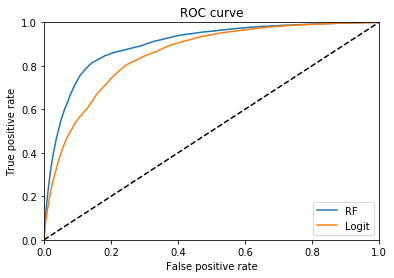

In [84]:
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_lr, tpr_lr, label='Logit')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [85]:
# pretty good!
print("Random Forest AUC Score:")
roc_auc_score(y_test, y_pred_rf)

Random Forest AUC Score:


0.8986313388601983

In [86]:
print("Logit AUC Score:")
roc_auc_score(y_test, y_pred_lr)

Logit AUC Score:


0.852644109912994

In [87]:
# let's see what was most important
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
#features = X_test.columns
#importances = rf.feature_importances_
#indices = np.argsort(importances)

In [88]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_test.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

In [89]:
importances.sort_values(by='Gini-importance', ascending=False)[0:50]

,Gini-importance
successful_shift_lag_2,0.104633
successful_shift_lag_5,0.065551
is_shift_lag_4,0.065506
is_shift_lag_5,0.056834
successful_shift_lag_1,0.048138
left_handed_batter,0.047800
successful_shift_lag_3,0.042267
avg_shifted_against,0.040683
is_shift_lag_2,0.040683
is_shift_lag_1,0.040017


In [90]:
score = pd.DataFrame(y_test)
score['pred_prob_rf'] = y_pred_rf
score['pred_prob_lr'] = y_pred_lr
score['pred_rf'] = np.where(score['pred_prob_rf']>=.25, 1, 0)
score['pred_lr'] = np.where(score['pred_prob_lr']>=.25, 1, 0)

In [91]:
score['pred_rf'].sum()

20907

In [92]:
from sklearn.metrics import accuracy_score

In [93]:
# a threshold of .25 works well
# some helpful discussion on thresholds: https://stats.stackexchange.com/questions/312119/classification-probability-threshold
print('for random forest:')
for threshold in [0.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]:
    print(accuracy_score(score['is_shift'], np.where(score['pred_prob_rf']>=threshold, 1, 0)))
    
print('for logistic regression: ') 
for threshold in [0.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]:
    print(accuracy_score(score['is_shift'], np.where(score['pred_prob_lr']>=threshold, 1, 0)))

for random forest:
0.13011215396604886
0.4914783315826924
0.7618676515433876
0.8807757033623601
0.8970679587526401
0.8966331221269723
0.8865471713030416
0.8758061419261568
0.8701419713346661
0.8698878460339512
for logistic regression: 
0.5697602186607031
0.7848292842702086
0.8267712533459831
0.8545725612441974
0.8732084166299596
0.8797253187860716
0.8815889043246479
0.8820124464925061
0.8805498142061691
0.8792227154135466


In [94]:
print("RF Accuracy: ")
print(accuracy_score(score['is_shift'], np.where(score['pred_prob_rf']>=.25, 1, 0)))

print('Logit Accuracy:')
print(accuracy_score(score['is_shift'], np.where(score['pred_prob_lr']>=.4, 1, 0)))

RF Accuracy: 
0.8970679587526401
Logit Accuracy:
0.8820124464925061


In [95]:
score['is_false_positive'] = np.where((score['pred_rf']==1) & (score['is_shift']==0), 1, 0)
score['is_false_negative'] = np.where((score['pred_rf']==0) & (score['is_shift']==1), 1, 0)
score['is_true_positive'] = np.where((score['pred_rf']==1) & (score['is_shift']==1), 1, 0)
score['is_true_negative'] = np.where((score['pred_rf']==0) & (score['is_shift']==0), 1, 0)

In [96]:
print('Accuracy Metrics for Random Forest')
score[['is_false_positive', 'is_false_negative', 'is_true_positive', 'is_true_negative']].mean()

Accuracy Metrics for Random Forest


is_false_positive    0.045443
is_false_negative    0.057489
is_true_positive     0.072623
is_true_negative     0.824445
dtype: float64

In [97]:
score['is_false_positive'] = np.where((score['pred_lr']==1) & (score['is_shift']==0), 1, 0)
score['is_false_negative'] = np.where((score['pred_lr']==0) & (score['is_shift']==1), 1, 0)
score['is_true_positive'] = np.where((score['pred_lr']==1) & (score['is_shift']==1), 1, 0)
score['is_true_negative'] = np.where((score['pred_lr']==0) & (score['is_shift']==0), 1, 0)

In [98]:
print('Accuracy Metrics for Logistic Regression')
score[['is_false_positive', 'is_false_negative', 'is_true_positive', 'is_true_negative']].mean()

Accuracy Metrics for Logistic Regression


is_false_positive    0.055806
is_false_negative    0.070986
is_true_positive     0.059126
is_true_negative     0.814082
dtype: float64